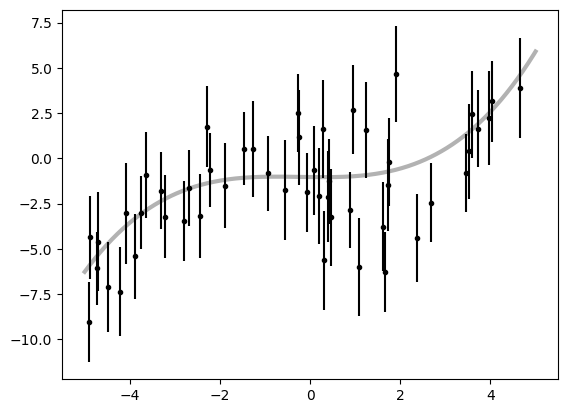

In [96]:
'''
Please run each cell individually.

**If the plotted fits for the quintic or quartic are not very good, i.e. one side shoots off to infinity, please
run THIS cell again to generate new data.

**Between runs of this program, please DELETE the output folders it creates, which in this case should be 'chainsMcomplete'.
Otherwise, the Cobaya MCMC chain sampling will not run and returns an error.
'''

'''
The purpose of this program is to test Bayesian Model Averaging in the M-complete case: the true data generator is not one
of the models chosen in BMA analysis.

At lower noise levels, it still works quite well. However at higher noise levels, BMA asympotically chooses the closest model
with little input from the others; it ends up working as model picking instead of model averaging.

This can be tested in this code. Below, in this cell, change the numbers in the 'yerr = ' line to 0.1 and 0.5 for the low-
noise case. Change the numbers to 2.0, 0.8 for the high-noise case.
'''

'''
Dependencies required (from repo):
FastMPClinpara
'''

'''
Directories that require changing (to work on your own device)

'''

# CREATE DATA FROM MODEL, CUBIC
import numpy as np
import matplotlib.pyplot as plt

#Step 1: create truth
dtrue = 0.05
atrue=0.034
btrue=-0.033
ctrue=-1.03
ftrue=0.5

#Step 2: generate random data around this model
N=50
xp = np.sort(10*np.random.rand(N)-5)
yerr = 2.0 + 0.8 * np.random.rand(N)
yp = dtrue*xp*xp*xp+atrue*xp*xp+btrue*xp+ctrue     #start with true y vals
yp += yerr * np.random.randn(N)

plt.errorbar(xp, yp, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(-5, 5, 500)
plt.plot(x0, dtrue*x0*x0*x0+atrue*x0*x0 + btrue*x0 + ctrue, "k", alpha=0.3, lw=3)

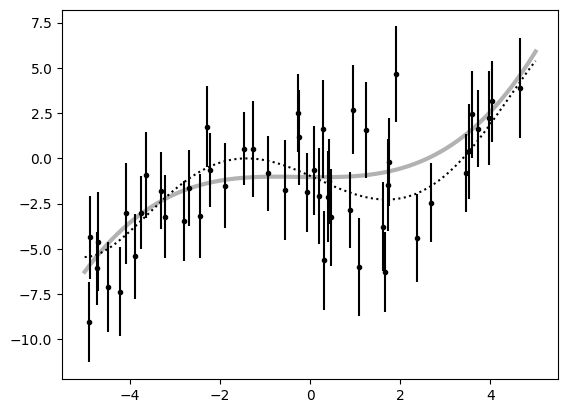

In [97]:
# FIT QUINTIC

def log_likelihoodquin(theta, xp, yp, yerr):
    log_f = np.log(ftrue)
    f, e, d, a, b, c  = theta
    model = f*xp*xp*xp*xp*xp + e*xp*xp*xp*xp + d*xp*xp*xp + a*xp*xp + b*xp +c
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((yp - model) ** 2 / sigma2 + np.log(sigma2))

from scipy.optimize import minimize

nll = lambda *args: -log_likelihoodquin(*args)
#this is an initial guess near the true values with some offset (required for minimization)
initial = np.array([0.01, 0.01, 0.01, 0.03,-1.0,-1.0])  #remember to change the # in the randn to # of params 
soln = minimize(nll, initial, args=(xp, yp, yerr))
F_ml, E_ml, D_ml, A_ml, B_ml, C_ml= soln.x

plt.errorbar(xp, yp, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, dtrue*x0*x0*x0+atrue*x0*x0 + btrue*x0 + ctrue, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 6), [F_ml, E_ml,D_ml, A_ml, B_ml, C_ml]), ":k", label="ML")

####################

def log_like_distquin(f, e, d, a, b, c):
    log_f = np.log(ftrue)
    model = f*xp*xp*xp*xp*xp + e*xp*xp*xp*xp + d*xp*xp*xp + a*xp*xp + b*xp + c
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((yp - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior_distquin(f, e, d, a, b, c):
    if 0.0 < f < 0.1 and 0.0 < e < 0.1 and 0.0 < d < 0.1 and 0.0 < a < 0.5 and -2.0 < b < 0.0 and -2.0 < c < 0.0:
        #the prior is saying that there is a 100% chance the parameters are within the above ranges, zero outside
        return 0.0      #this is log prior, so ln(1) = 0,
    return -np.inf 

def log_post_distquin(f, e, d, a, b, c):
    lp = log_prior_distquin(f, e, d, a, b, c)

    if not np.isfinite(lp):     #checks if the parameters are within the ranges given by the prior
        return -np.inf          #log, so this really returns a 0% chance (outside prior range)
    return lp + log_like_distquin(f, e, d, a, b, c)

##########################

infoquin = {
    "likelihood": {
        "log_prob": log_post_distquin
                    },
    "params": dict([
        ("f",
            {"prior": {"min": 0.0, "max": 0.1}}
        ),
        ("e",
            {"prior": {"min": 0.0, "max": 0.1}}
        ),
        ("d", 
            {"prior": {"min": 0.0, "max": 0.1}}
        ),
        ("a", 
            {"prior": {"min": 0.0, "max": 0.5}}
        ),
        ("b", 
            {"prior": {"min": -2.0, "max": 0.0}}
        ),
        ("c",
            {"prior": {"min": -2.0, "max": 0.0}}
        )
            ]),
    "sampler": {
        "mcmc": {"burn_in": 200, "max_tries": 250}}, "output": "chainsMcomplete/mcmcquin",
}

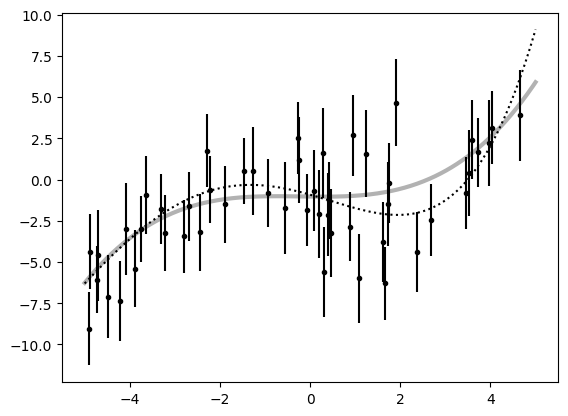

In [98]:
# FIT QUARTIC

def log_likelihoodquar(theta, xp, yp, yerr):
    log_f = np.log(ftrue)
    e, d, a, b, c  = theta
    model = e*xp*xp*xp*xp + d*xp*xp*xp + a*xp*xp + b*xp +c
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((yp - model) ** 2 / sigma2 + np.log(sigma2))

from scipy.optimize import minimize

nll = lambda *args: -log_likelihoodquar(*args)
#this is an initial guess near the true values with some offset (required for minimization)
initial = np.array([0.01, 0.01, 0.03,-1.0,-1.0])  #remember to change the # in the randn to # of params 
soln = minimize(nll, initial, args=(xp, yp, yerr))
E_ml, D_ml, A_ml, B_ml, C_ml= soln.x

plt.errorbar(xp, yp, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, dtrue*x0*x0*x0+atrue*x0*x0 + btrue*x0 + ctrue, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 5), [E_ml, D_ml, A_ml, B_ml, C_ml]), ":k", label="ML")

####################

def log_like_distquar(e, d, a, b, c):
    log_f = np.log(ftrue)
    model = e*xp*xp*xp*xp + d*xp*xp*xp + a*xp*xp + b*xp + c
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((yp - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior_distquar(e, d, a, b, c):
    if 0.0 < e < 0.1 and 0.0 < d < 0.1 and 0.0 < a < 0.5 and -2.0 < b < 0.0 and -2.0 < c < 0.0:
        #the prior is saying that there is a 100% chance the parameters are within the above ranges, zero outside
        return 0.0      #this is log prior, so ln(1) = 0,
    return -np.inf 

def log_post_distquar(e, d, a, b, c):
    lp = log_prior_distquar(e, d, a, b, c)

    if not np.isfinite(lp):     #checks if the parameters are within the ranges given by the prior
        return -np.inf          #log, so this really returns a 0% chance (outside prior range)
    return lp + log_like_distquar(e, d, a, b, c)

##########################

infoquar = {
    "likelihood": {
        "log_prob": log_post_distquar
                    },
    "params": dict([
        ("e",
            {"prior": {"min": 0.0, "max": 0.1}}
        ),
        ("d", 
            {"prior": {"min": 0.0, "max": 0.1}}
        ),
        ("a", 
            {"prior": {"min": 0.0, "max": 0.5}}
        ),
        ("b", 
            {"prior": {"min": -2.0, "max": 0.0}}
        ),
        ("c",
            {"prior": {"min": -2.0, "max": 0.0}}
        )
            ]),
    "sampler": {
        "mcmc": {"burn_in": 200, "max_tries": 250}}, "output": "chainsMcomplete/mcmcquar",
}

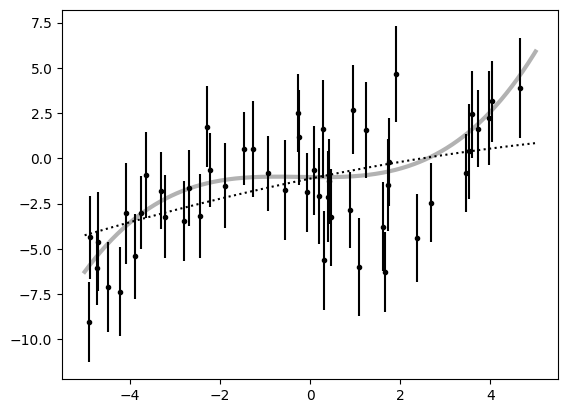

In [99]:
# FIT PARABOLA

def log_likelihoodpara(theta, xp, yp, yerr):
    log_f = np.log(ftrue)
    a, b, c = theta
    model = a*xp*xp + b*xp + c
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((yp - model) ** 2 / sigma2 + np.log(sigma2))

from scipy.optimize import minimize

nll = lambda *args: -log_likelihoodpara(*args)
#this is an initial guess near the true values with some offset (required for minimization)
initial = np.array([atrue, btrue, ctrue]) + 0.1 * np.random.randn(3) #remember to change the # in the randn to # of params 
soln = minimize(nll, initial, args=(xp, yp, yerr))
a_ml, b_ml, c_ml= soln.x

plt.errorbar(xp, yp, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, dtrue*x0*x0*x0+atrue*x0*x0 + btrue*x0 + ctrue, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 3), [a_ml, b_ml, c_ml]), ":k", label="ML")

#####################################

def log_like_distpara(a, b, c):
    log_f = np.log(ftrue)
    model = a*xp*xp + b*xp + c
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((yp - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior_distpara(a,b,c, log_f):
    if -1.0 < a < 1.0 and -0.5 < b < 0.0 and -2.0 < c < 0.0 and -1.0 < log_f < 1.0:
        #the prior is saying that there is a 100% chance the parameters are within the above ranges, zero outside
        return 0.0      #this is log prior, so ln(1) = 0,
    return -np.inf 

def log_post_distpara(a, b, c, log_f):
    lp = log_prior_distpara(a, b, c, log_f)

    if not np.isfinite(lp):     #checks if the parameters are within the ranges given by the prior
        return -np.inf          #log, so this really returns a 0% chance (outside prior range)
    return lp + log_like_distpara(a, b, c)

##########################

infopara = {
    "likelihood": {
        "log_prob": log_post_distpara
                    },
    "params": dict([
        ("log_f", 
            {"prior": {"min": -1.0, "max": 1.0}}
        ),
        ("a", 
            {"prior": {"min": -1.0, "max": 1.0}}
        ),
        ("b", 
            {"prior": {"min": -0.5, "max": 0.0}}
        ),
        ("c", 
            {"prior": {"min": -2.0, "max": 0.0}}
        )
            ]),
    "sampler": {
        "mcmc": {"burn_in": 200, "max_tries": 250}}, "output": "chainsMcomplete/mcmcpara",
}

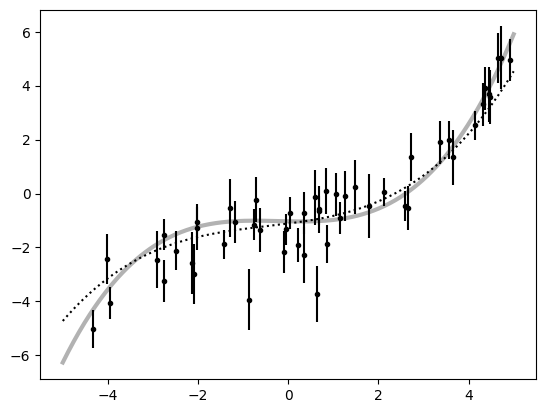

In [164]:
# FIT CUBIC
#running this cell is not required, since BMA only takes the other models

def log_likelihoodcube(theta, xp, yp, yerr):
    log_f = np.log(ftrue)
    d, a, b, c  = theta
    model = d*xp*xp*xp + a*xp*xp + b*xp +c
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((yp - model) ** 2 / sigma2 + np.log(sigma2))

from scipy.optimize import minimize

nll = lambda *args: -log_likelihoodcube(*args)
#this is an initial guess near the true values with some offset (required for minimization)
initial = np.array([0.01, 0.03,-1.0,-1.0])  #remember to change the # in the randn to # of params 
soln = minimize(nll, initial, args=(xp, yp, yerr))
D_ml, A_ml, B_ml, C_ml= soln.x

plt.errorbar(xp, yp, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, dtrue*x0*x0*x0+atrue*x0*x0 + btrue*x0 + ctrue, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 4), [D_ml, A_ml, B_ml, C_ml]), ":k", label="ML")

####################

def log_like_distcube(d, a, b, c):
    log_f = np.log(ftrue)
    model = d*xp*xp*xp + a*xp*xp + b*xp + c
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((yp - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior_distcube(d, a, b, c):
    if 0.0 < d < 0.1 and 0.0 < a < 0.5 and -2.0 < b < 0.0 and -2.0 < c < 0.0:
        #the prior is saying that there is a 100% chance the parameters are within the above ranges, zero outside
        return 0.0      #this is log prior, so ln(1) = 0,
    return -np.inf 

def log_post_distcube(d, a, b, c):
    lp = log_prior_distcube(d, a, b, c)

    if not np.isfinite(lp):     #checks if the parameters are within the ranges given by the prior
        return -np.inf          #log, so this really returns a 0% chance (outside prior range)
    return lp + log_like_distcube(d, a, b, c)

##########################

infocube = {
    "likelihood": {
        "log_prob": log_post_distcube
                    },
    "params": dict([
        ("d", 
            {"prior": {"min": 0.0, "max": 0.1}}
        ),
        ("a", 
            {"prior": {"min": 0.0, "max": 0.5}}
        ),
        ("b", 
            {"prior": {"min": -2.0, "max": 0.0}}
        ),
        ("c",
            {"prior": {"min": -2.0, "max": 0.0}}
        )
            ]),
    "sampler": {
        "mcmc": {"burn_in": 200, "max_tries": 250}}, "output": "chainsMcomplete/mcmccube",
}

In [101]:
import cobaya
from cobaya.run import run
updated_infopara, samplerpara = run(infopara)
gdsamplepara = samplerpara.products(to_getdist=True)["sample"]
updated_infoquar, samplerquar = run(infoquar)
gdsamplequar = samplerquar.products(to_getdist=True)["sample"]
updated_infoquin, samplerquin = run(infoquin)
gdsamplequin = samplerquin.products(to_getdist=True)["sample"]

[output] Output to be read-from/written-into folder 'chainsMcomplete', with prefix 'mcmcpara'
[log_prob] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] Initial point: log_f:-0.3906826, a:0.4380359, b:-0.002179114, c:-0.7611819
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {log_prob: 16400.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling! (NB: no accepted step will be saved until 200 burn-in samples have been obtained)
[mcmc] Progress @ 2025-01-21 14:23:35 : 1 steps taken -- still burning in, 201 accepted steps left.
[mcmc] Finis

In [102]:
import FastMPClinpara as fmpc

roots = ["\mcmcquar.1.txt", "\mcmcpara.1.txt", "\mcmcquin.1.txt"] # this might not be correct
models = [ "quar", "para", "quin"]
temperature = { 'quar': 1, 'para': 1, 'quin': 1}
model_prior = {'quar': 0.3, 'para': 0.3, 'quin': 0.3}
parameters = {'quar':['e','d','a','b', 'c'], 'para':['a','b','c'],'quin':['f','e','d','a','b','c']}
burnin = [0.3,0.3,0.3]
chainpath = "C:/Users/zombk/Documents/vscode/.venv/W2025coopcode/.venv/code_for_getting_started/BMA_stuff/chainsMcomplete"
out = fmpc.run(roots=roots, models=models, chainDir=chainpath, burnin=burnin,
               priors=model_prior, temperature=temperature, pars=parameters, estimator='learnt harmonic')

Computing evidence for model:  quar
Computing evidence for model:  para
Computing evidence for model:  quin


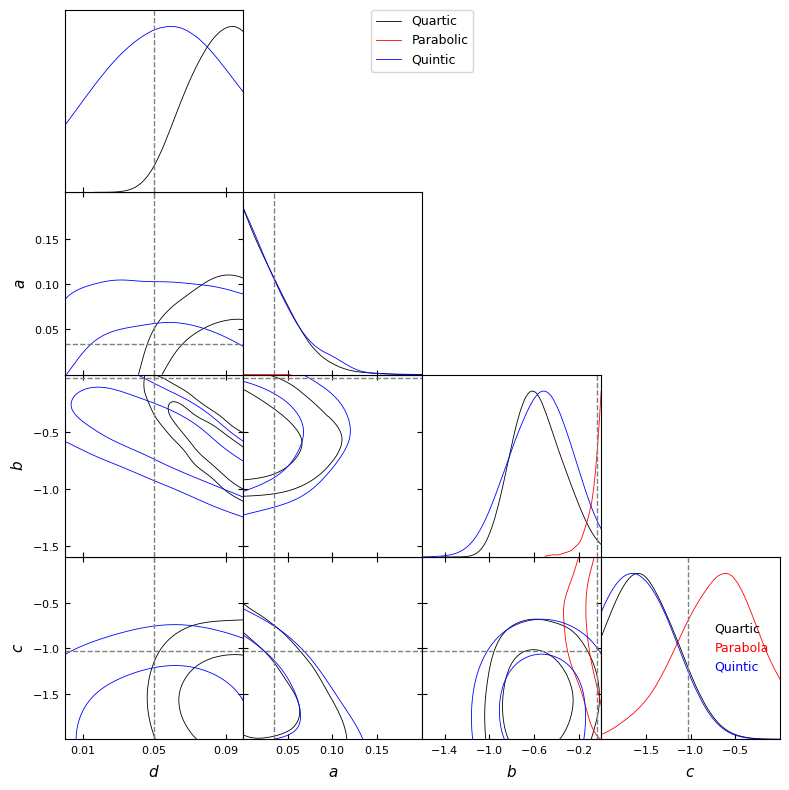

In [103]:
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
from getdist import loadMCSamples

g = plots.get_subplot_plotter()
g.triangle_plot([gdsamplequar, gdsamplepara, gdsamplequin], ['d', 'a', 'b', 'c'], filled=False, legend_labels=['Quartic', 'Parabolic', 'Quintic'], 
                markers={'a':atrue,'b':btrue,'c':ctrue, 'd':dtrue},  marker_args={'lw': 1})
g.add_legend(['Quartic', 'Parabola',  'Quintic'], colored_text=True);

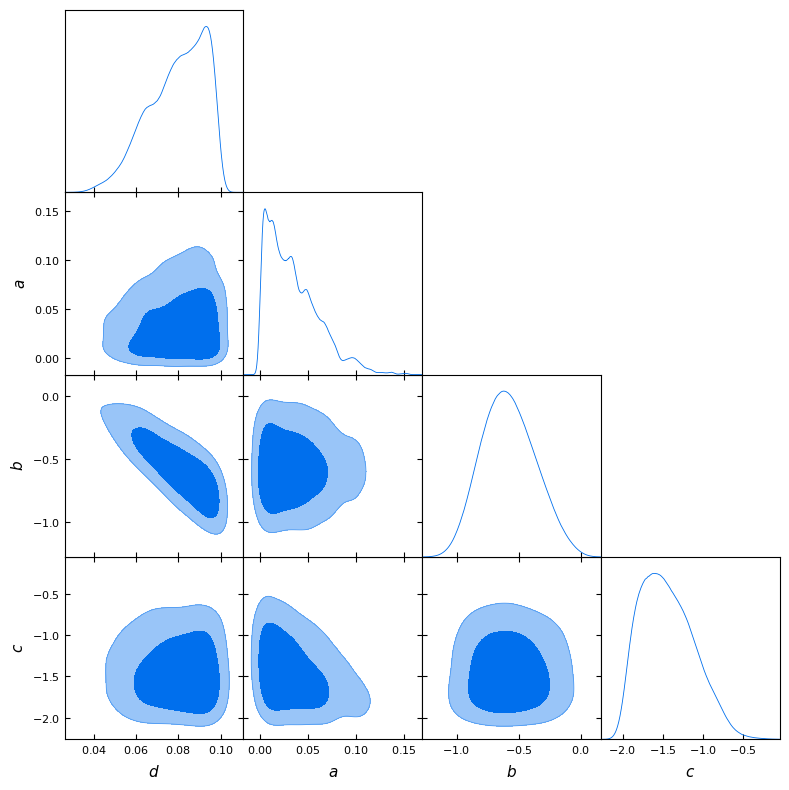

In [104]:
import numpy as np
import pandas as pd
import math as m
from getdist import MCSamples
import matplotlib.pyplot as plt
from getdist.plots import GetDistPlotter


outnewchains=out['newchains']['Reweighted']
length = np.shape(outnewchains['b'])[0]
#print(length)
arraybma = np.zeros(shape=(length, 4))      #change 3/4 is adding/taking away weight column
#print(arraybma)
#print(outnewchains['a'])
for i in range(length):
    arraybma[i][1] = outnewchains['a'][i]
    arraybma[i][2] = outnewchains['b'][i]
    arraybma[i][3] = outnewchains['c'][i]
    arraybma[i][0] = outnewchains['d'][i]
    #arraybma[i][3] = outnewchains['weight'][i]

newlength = 0
#print(length)
for i in range(length):
    if m.isnan(arraybma[i][0]):
        #print("break here")
        break
    newlength+=1

arraybma = arraybma[:newlength]
newweights = outnewchains['weight'].to_numpy() 
newweights = newweights[:newlength]


MCbmasamples = MCSamples(samples=arraybma, weights=newweights, names = ['d','a','b','c'], labels=['d','a','b','c'], label="BMA")

g = GetDistPlotter()
# Add the sample to the plotter
g.triangle_plot([MCbmasamples], filled=True)
# Show the plot
plt.show()

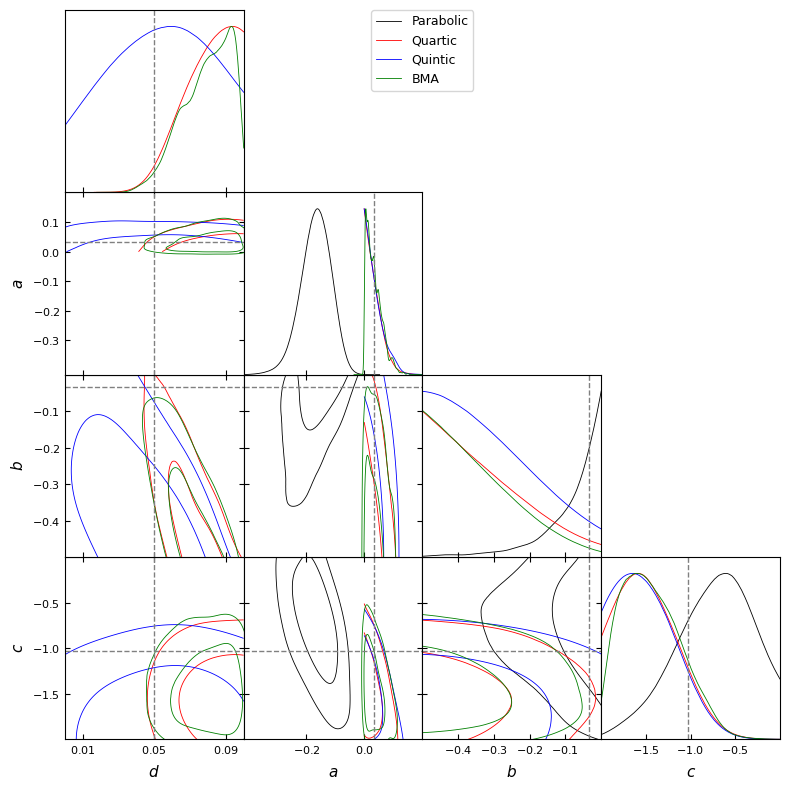

In [105]:
g = plots.get_subplot_plotter()
g.triangle_plot([gdsamplepara, gdsamplequar, gdsamplequin, MCbmasamples], ['d', 'a', 'b', 'c'], filled=False, legend_labels=['Parabolic','Quartic', 'Quintic','BMA'], 
                markers={'a':atrue,'b':btrue,'c':ctrue, 'd':dtrue}, marker_args={'lw': 1})